In [431]:
metadata = {
    'Author      ': 'Jay Annadurai',
    'Date        ': '12 Apr 2024',
    'Project     ': 'A5-PPIN-Analyzer',
    'Version     ': 1.0,
    'Description ': 'Protein-Protein Network Interaction Analytics Tool'
}

In [432]:
# ~~~~~~~~~~~~~~~~~~
#  Import Libraries
# ~~~~~~~~~~~~~~~~~~
import networkx as nx # Network Analysis Tools (Only used for Shortest Path Length Computation)
import pandas as pd  # Data Reading
import numpy as np  # Computation
import scipy as sp # Statistical Methods
import seaborn as sns  # Advanced Data Visualization
import matplotlib.pyplot as plt  # Data Visualization
# Set Matplot to Inline
%matplotlib inline 

# ~~~~~~~~~~~~~~~~~~~~~~~
#  Import Utlity Classes
# ~~~~~~~~~~~~~~~~~~~~~~~
from pprint import pprint as pp  # Override the standard print function with Pretty Print
from JayUtilities import DataIO as Jio  # Data Input/Output Processing Utility Class

In [433]:
# ~~~~~~~~~~~~~~~
#  Script Config
# ~~~~~~~~~~~~~~~
# Input Config
Jio.input_folder = "Input/"  # Sets the Input Folder for the DataIO Class
input_file_paths = { # Name of the Input File
    'Human-PPI':'Human-PPI.txt',
    'Protein-L1':'protein-list1.txt',
    'Protein-L2':'protein-list2.txt'
}

input_format = 'tsv'  # Optionally force the encode format of the Input File
header_rows = 0  # Ptt files contain 2 rows of header information

# Output Config
Jio.output_folder = "Output/"  # Sets the Output Folder for the DataIO Class
save_file = False  # Sets whether the script should save the outputs or not
output_file = None  # Name of the Output File is generated Dynamically
output_format = 'tsv'  # Format of the file to save the Output as

In [434]:
# ~~~~~~~~~~~~~ 
#  Import Data
# ~~~~~~~~~~~~~
# Initialize a dict to contain the file Dataframes
dfs = {}
input_files = {}
# Import the Data from Each Input File
for file_name,file_path in input_file_paths.items():

    # Only Human PPI File has a header
    if file_name == 'Human-PPI':
        header_arg = 0
    else:
        header_arg = None
    
    # Read the Input Files as Dicts
    input_file_dict = Jio.file_to_df(
        file_name=file_path,
        force_encode_format=input_format,
        read_args= { 
            "header": header_arg,
        }
    )
    
    # Rebind the Input File Dict instead of just the file path
    input_files[file_name] = input_file_dict
    
    # Grab the DF from the Input File
    dfs[file_name] = input_file_dict['df']
    

In [435]:
Jio.print_df(dfs,show_dtypes=True)

DataFrame

~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Human-PPI: 80070 Row x 1 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~~~

< Col Types > : [ OFFICIAL_SYMBOL_A       OFFICIAL_SYMBOL_B: object ]

              OFFICIAL_SYMBOL_A       OFFICIAL_SYMBOL_B
1810055G02Rik                                     MPRIP
1810055G02Rik                                     RAI14
1810055G02Rik                                      TPM1
2810046L04Rik                                      ARF1
2810046L04Rik                                      ARF3
4922501C03Rik                                     CPNE4
4930572J05Rik                                   C8orf55
4930572J05Rik                                     PRKDC
4930572J05Rik                                    SPRR2B
4930572J05Rik                                    SPRR2D
~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~
Protein-L1: 50 Row x 1 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~

< Col Types > : [ 0: object ]

         0
0    LAS1L
1    FKBP4
2     RBM6
3     UPF1
4  SLC25A5
5   

In [436]:
# Clean up Each of the Dataframes
# Set the column names correctly for the Human PPI
dfs['Human-PPI'].reset_index(inplace=True)

dfs['Human-PPI'].rename(columns={'OFFICIAL_SYMBOL_A       OFFICIAL_SYMBOL_B': 'B','index': 'A',}, inplace=True)

dfs['Human-PPI'].dropna(inplace=True)

dfs['Human-PPI']

# Set the Name of the Columns in the Protein List
for protein_list in ['Protein-L1','Protein-L2']:
    dfs[protein_list].rename(columns={0: 'Protein'},inplace=True)

In [437]:
Jio.print_df(dfs,show_dtypes=True)

DataFrame

~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Human-PPI: 80067 Row x 2 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~~~

< Col Types > : [ A: object, B: object ]

               A        B
0  1810055G02Rik    MPRIP
1  1810055G02Rik    RAI14
2  1810055G02Rik     TPM1
3  2810046L04Rik     ARF1
4  2810046L04Rik     ARF3
5  4922501C03Rik    CPNE4
6  4930572J05Rik  C8orf55
7  4930572J05Rik    PRKDC
8  4930572J05Rik   SPRR2B
9  4930572J05Rik   SPRR2D
~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~
Protein-L1: 50 Row x 1 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~

< Col Types > : [ Protein: object ]

   Protein
0    LAS1L
1    FKBP4
2     RBM6
3     UPF1
4  SLC25A5
5    DHX33
6    ELAC2
7  CCDC124
8    RPS20
9    CSDE1
~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~
Protein-L2: 32 Row x 1 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~

< Col Types > : [ Protein: object ]

   Protein
0    GNL3L
1     FMR1
2    FRAXA
3     UBA1
4    CSTF2
5    MECP2
6     PHF6
7    RBM10
8    GSPT2
9  SLC25A5
~~~~~~~~~~~~~~~~~~~~~~~~~~




In [438]:
# The PPI DF represents all the edges in a PPI network
# Get all unique values of the edge endpoints, aka the nodes

# First concatenate the columns together and get only the unique valuese
nodes = pd.concat([dfs['Human-PPI']['A'], dfs['Human-PPI']['B']]) 
# Drop Duplicates and any NA values then sort and reset index
nodes = nodes.copy().drop_duplicates().dropna().sort_values().reset_index(drop=True)

# Rename the column of Results
nodes.name = 'Node'

# Convert it into a dataframe
nodes_df = pd.DataFrame(nodes)

In [439]:
nodes_df

,Node
0,1700006A11Rik
1,1810055G02Rik
2,2810046L04Rik
3,4922501C03Rik
4,4930572J05Rik
...,...
14660,vpr
14661,vpu
14662,vpx
14663,wee1B


In [440]:
# ~~~~~~~~~~~~~~~~~~~~~
#  Network Connections
# ~~~~~~~~~~~~~~~~~~~~~

# Returns a dataframe of all the directional connections in the dataframe
# In a network that is nondirectional, will contain a duplicate per edge
def network_connections(network_df,col_start_node,col_end_node)-> pd.DataFrame:
    
    # Create two duplicate dataframes
    
    # First dataframe will be edgesAtoB with original A to B relationships
    edges_start_to_end_df = network_df.copy() 
    
    # Second dataframe is edgesBtoA with flipped column order and B to A relationships
    edges_end_to_start_df = network_df.copy()
    edges_end_to_start_df.rename(columns={
        # Flip the Start and End Columns by renaming them
        col_start_node: col_end_node,
        col_end_node: col_start_node
    }, inplace=True)

    # Third dataframe merges the first columns and second columns of both dataframes
    network_connections_df = pd.concat([
        edges_start_to_end_df, edges_end_to_start_df
    ])
    
    # Rename the columns to represent that this contains bilateral connections
    network_connections_df.rename(columns={
        col_start_node: 'Node', col_end_node: 'ConnectedNode'
    }, inplace=True)
    
    # Return the dataframe of connections
    return network_connections_df


In [441]:
# ~~~~~~~~~~~~~~~~~
#  Degree of Nodes
# ~~~~~~~~~~~~~~~~~

# Define an algorithm to compute the network degrees per node
# Requires an input df of the incoming and outgoing connections per node
def network_degrees_per_node(network_connections_df,col_node)-> pd.Series:
    # Group_by the first column of all edges which should provide incoming and outgoing edges per node
    # Degree of each node is simply the amount of connected nodes
    # Can be attained with the length of each group 
    node_degrees_series = network_connections_df.groupby(col_node).size()

    # Rename the series
    node_degrees_series.name = 'Connections_Count'
    
    # Sort the series by the node with the highest connection count
    node_degrees_series.sort_values(ascending=False, inplace=True)
    
    # Return a series of the results
    return node_degrees_series


In [442]:
# Initialize a result set for analytics on the Human PPI Network
hppi_dfs = {}

# Bind the results of the network connections function on the Human PPI df
hppi_dfs['Connections'] = network_connections(dfs['Human-PPI'],'A','B')

# Feed the connections dataframe into the network degrees per node function
hppi_dfs['Degrees']  = network_degrees_per_node(hppi_dfs['Connections'] ,'Node')

In [443]:
# View the Connections DF
hppi_dfs['Connections']

,Node,ConnectedNode
0,1810055G02Rik,MPRIP
1,1810055G02Rik,RAI14
2,1810055G02Rik,TPM1
3,2810046L04Rik,ARF1
4,2810046L04Rik,ARF3
...,...,...
80065,VprBP,vpr
80066,BST2,vpu
80067,BTRC,vpu
80068,UBC,vpu


In [444]:
# View the Degrees DF
hppi_dfs['Degrees']

Node
UBC           9313
SUMO2         1174
SIRT7          662
TP53           605
HDAC1          602
              ... 
MCTP2            1
MCOLN3           1
MCM9             1
MCM3AP-AS1       1
zbtb16a          1
Name: Connections_Count, Length: 14665, dtype: int64

In [445]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Local Clustering Coefficients
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Function to compute the local clustering coefficients 
# In preparation for the total clustering coefficient
# Requires an input df of the incoming and outgoing connections per node
def compute_local_clustering(network_connections_df,col_node,col_connected_node_name)-> pd.DataFrame:
    
    # Debug Enabled
    debug = 10;

    # List to hold the clustering coefficients and other metrics for each node
    clustering_coefficients_data = []

    # Iterate over each node and its connections
    for node, connections in network_connections_df.groupby(col_node):

        # Initialize dictionary for current node
        node_data = {}
        node_data['Node'] = node
        
        # Identify all the neighbors per that node
        neighbors = connections[col_connected_node_name].unique()
        node_data['neighbor_count'] = len(neighbors)

        # Ensure the node itself is not included in its list of neighbors
        neighbors = neighbors[neighbors != node]

        # Include only the edges where the starting node is one of the neighbors
        # Consider connections that initiate from within the neighbor set
        is_starting_node_neighbor = network_connections_df[col_node].isin(neighbors)
        
        # Include only the edges where the ending node is also one of the neighbors
        # Ensures that the connection is contained within the neighborhood and not externally
        is_ending_node_neighbor = network_connections_df[col_connected_node_name].isin(neighbors)
        
        # Exclude self-loops by ensuring that the starting and ending nodes are not the same.
        is_not_self_loop = network_connections_df[col_node] != network_connections_df[col_connected_node_name]
        
        # Filter based on the above conditions  to create a subgraph that includes only the valid edges where both nodes are neighbors and there are no self-loops. 
        subgraph = network_connections_df[
            is_starting_node_neighbor & is_ending_node_neighbor & is_not_self_loop
        ]

        # Deduplicate the subgraph to ensure each unique edge is counted only once
        # Prevent double counting of bidirectional edges in the subgraph
        # Bidirectional edges are where both directions of an interaction are recorded
        subgraph = subgraph.drop_duplicates()

        # Count the number of actual links between neighbors
        # Each edge is normally counted twice in an undirected graph
        # However, the network_connections_df already has the symmetrical connections
        node_data['bi_links'] = len(subgraph)
        
        # The actual links is then divided by 2
        # Compensates for both incoming and outgoing connections
        node_data['links'] = node_data['bi_links'] / 2

        # Calculate the number of possible links between neighbors
        # Represents the multiplex where all neighbors are connected to all other neighbors
        k = node_data['neighbor_count']
        node_data['possible_links'] = k * (k - 1) / 2

        # Avoid dividing by zero for the local clustering coefficient
        if node_data['possible_links']> 0:
            # Calculate clustering coefficient for this node
            node_data['clustering_coef'] = node_data['links'] / node_data['possible_links']
        else:
            # Otherwise set the clustering coefficient manually to zero
            node_data['clustering_coef'] = 0
            
        # Debug
        if node_data['clustering_coef'] > 1 and debug >= 0 :
            print(f"Subgraph for node {node} (expected neighbors only) with Coef of {node_data['clustering_coef']}:")
            
            print(subgraph)
            
            debug=debug-1
            
        # Add node data to the list of data
        clustering_coefficients_data.append(node_data)

        # End loop per node
        
    # Convert the data which is a list of dictionaries into a DataFrame
    local_clustering_coefs_df = pd.DataFrame(clustering_coefficients_data)
    
    # Set 'Node' as the index of the dataframe
    local_clustering_coefs_df.set_index('Node', inplace=True)

    # Return the DF
    return local_clustering_coefs_df

In [446]:
hppi_dfs['Local Clustering Coefs'] = compute_local_clustering(hppi_dfs['Connections'],'Node','ConnectedNode')

In [447]:
# View the DF
hppi_dfs['Local Clustering Coefs']

,neighbor_count,bi_links,links,possible_links,clustering_coef
Node,,,,,
1700006A11Rik,1,0,0.0,0.0,0.000000
1810055G02Rik,3,0,0.0,3.0,0.000000
2810046L04Rik,2,0,0.0,1.0,0.000000
4922501C03Rik,1,0,0.0,0.0,0.000000
4930572J05Rik,6,0,0.0,15.0,0.000000
...,...,...,...,...,...
vpr,8,24,12.0,28.0,0.428571
vpu,5,10,5.0,10.0,0.500000
vpx,1,0,0.0,0.0,0.000000


In [448]:
# Inspect the Summary Stats of the Clustering Coefficients DF
summary_stats = hppi_dfs['Local Clustering Coefs'].describe()
summary_stats

,neighbor_count,bi_links,links,possible_links,clustering_coef
count,14665.000000,14665.000000,14665.000000,1.466500e+04,14665.000000
mean,9.552881,39.829935,19.914968,2.848303e+03,0.205175
std,74.935204,625.420325,312.710163,3.093841e+05,0.293893
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,3.000000,2.000000,1.000000,3.000000e+00,0.063123
75%,8.000000,14.000000,7.000000,2.800000e+01,0.330882
max,8656.000000,72634.000000,36317.000000,3.745884e+07,1.000000


In [449]:
# View and optionally sort the dataframe by the clustering coefficients to debug
Jio.print_df(
    hppi_dfs['Local Clustering Coefs']
    #.sort_values(by='clustering_coef',ascending=False)
    ,
    df_name='Local Clustering Coefficients per Node',
    show_dtypes=True
)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Local Clustering Coefficients per Node: 14665 Row x 5 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

< Col Types > : [ neighbor_count: int64, bi_links: int64, links: float64, possible_links: float64, clustering_coef: float64 ]

               neighbor_count  bi_links  links  possible_links  \
Node                                                             
1700006A11Rik               1         0    0.0             0.0   
1810055G02Rik               3         0    0.0             3.0   
2810046L04Rik               2         0    0.0             1.0   
4922501C03Rik               1         0    0.0             0.0   
4930572J05Rik               6         0    0.0            15.0   
9830001H06Rik               9        10    5.0            36.0   
A1BG                        7         2    1.0            21.0   
A1CF                        6         4    2.0            15.0   
A2M                        36        1

In [450]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Total Clustering Coefficient
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Function computes the total clustering coefficient of the network
# Input df must contain be indexed by node and contain the local clustering coefficients
def compute_total_clustering_coef(local_cluster_coefs_df, col_cluster_coef, ):

    # Calculate the total clustering coefficient as the mean of the local clustering coefficients
    total_clustering_coef = local_cluster_coefs_df[col_cluster_coef].mean()

    # Return the total clustering coefficient
    return total_clustering_coef

In [451]:
# Calculate the total clustering coefficient from the local clustering coefficients
hppi_dfs['Total Clustering Coefficient'] = compute_total_clustering_coef(hppi_dfs['Local Clustering Coefs'],'clustering_coef')

# View the Value
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"TOTAL CLUSTERING COEFFICIENT [DE NOVO] : {hppi_dfs['Total Clustering Coefficient']}")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TOTAL CLUSTERING COEFFICIENT [DE NOVO] : 0.20517480748187397
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [470]:
# Validate the Total Clustering Coefficient with External Package
# import networkx as nx

# Create a graph from the DataFrame
nx_human_ppi_graph = nx.from_pandas_edgelist(dfs['Human-PPI'], 'A', 'B')

# Calculate local clustering coefficients for all nodes
nx_local_clustering_coefs = nx.clustering(nx_human_ppi_graph )

# Calculate the average clustering coefficient (total clustering coefficient)
nx_total_clustering_coef = nx.average_clustering(nx_human_ppi_graph )

print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"TOTAL CLUSTERING COEFFICIENT [NetworkX] : {nx_total_clustering_coef}")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

print(f"Total Clustering Coefficient from NetworkX Package: {nx_total_clustering_coef}")
print(f"Local Clustering Coefficients from NetworkX Package:\n")
pp(nx_local_clustering_coef)

# Print again just so it's not missed
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"TOTAL CLUSTERING COEFFICIENT [NetworkX] : {nx_total_clustering_coef}")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# Output:
# Total Clustering Coefficient from NetworkX Package: 0.20981404670001005

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TOTAL CLUSTERING COEFFICIENT [NetworkX] : 0.20981404670001005
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Clustering Coefficient from NetworkX Package: 0.20981404670001005
Local Clustering Coefficients from NetworkX Package:

{'1700006A11Rik': 0,
 '1810055G02Rik': 0,
 '2810046L04Rik': 0,
 '4922501C03Rik': 0,
 '4930572J05Rik': 0,
 '9830001H06Rik': 0.1388888888888889,
 'A1BG': 0.047619047619047616,
 'A1CF': 0.13333333333333333,
 'A2M': 0.012698412698412698,
 'AAAS': 0,
 'AACS': 0,
 'AADAC': 0,
 'AAGAB': 1.0,
 'AAMP': 0.3,
 'AANAT': 0,
 'AARS': 0,
 'AARS2': 1.0,
 'AARSD1': 1.0,
 'AASDHPPT': 0.4,
 'AASS': 0.5,
 'AATF': 0.10952380952380952,
 'AATK': 0,
 'ABCA1': 0.11029411764705882,
 'ABCA13': 0,
 'ABCA2': 0.6666666666666666,
 'ABCA3': 0,
 'ABCA4': 0,
 'ABCA7': 0,
 'ABCB1': 0.6666666666666666,
 'ABCB10': 0,
 'ABCB11': 0,
 'ABCB6': 0.3333333333333333,
 'ABCB7': 0.3333333333333333,
 'ABCB8': 1.0,
 'ABCB9':

In [453]:
# ~~~~~~~~~~~~~~~~~~~~~~~~
#  Prepare for Power Plot
# ~~~~~~~~~~~~~~~~~~~~~~~~
# Copy the Dataframe in Preparation for Plotting
degrees_df = pd.DataFrame(hppi_dfs['Degrees']).copy().reset_index()
Jio.print_df(degrees_df,df_name='Degrees DF for Plot')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Degrees DF for Plot: 14665 Row x 2 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    Node  Connections_Count
0    UBC               9313
1  SUMO2               1174
2  SIRT7                662
3   TP53                605
4  HDAC1                602
5  SUMO1                588
6    MYC                498
7  EP300                423
8  HDAC2                375
9  HDAC5                350
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [454]:

# Get the Counts Data
degrees = degrees_df['Connections_Count'].value_counts().sort_index()
print(f"Degrees \n {degrees} \n\n")

# Get the Frequency Data
# Note: Psuedocount or zero drop is not necessary due to preprocessing
degree_frequencies = degrees.values
print(f"Degree Frequencies \n {degree_frequencies} \n\n")

Degrees 
 Connections_Count
1       4507
2       1924
3       1280
4        926
5        688
        ... 
602        1
605        1
662        1
1174       1
9313       1
Name: count, Length: 206, dtype: int64 


Degree Frequencies 
 [4507 1924 1280  926  688  554  461  380  336  276  253  217  210  180
  148  144  133  114  113   99   90   73   71   73   73   51   53   67
   49   36   52   54   36   34   33   38   27   36   35   29   22   15
   20   18   14   17   16   20   20   13   19   25   10   11   15   18
    8   14    6   10   11   10   14    7    9   14    9    7    9    6
    8    6    5    5    7    5    7    6    4    6    4    4    8    3
    5    5    3    3    2    4    3    3    4    6    6    2    1    4
    2    2    1    4    1    3    1    3    2    6    2    1    3    6
    3    5    5    3    2    1    1    1    2    3    2    3    6    2
    2    1    2    1    1    1    2    1    1    1    2    2    1    1
    2    1    1    1    2    1    1    3    2    1    1 

In [455]:

# Natural log-transform the degree index / labels and their corresponding frequencies
log_degrees = np.log(degrees.index)
print(f"Ln Degrees \n {log_degrees} \n\n")

log_degree_frequencies = np.log(degree_frequencies)
print(f"Ln Degree Frequency \n {log_degree_frequencies} \n\n")

Ln Degrees 
 Index([               0.0, 0.6931471805599453, 1.0986122886681098,
       1.3862943611198906, 1.6094379124341003,  1.791759469228055,
       1.9459101490553132, 2.0794415416798357, 2.1972245773362196,
        2.302585092994046,
       ...
        5.857933154483459,  5.926926025970411, 6.0473721790462776,
        6.210600077024653,  6.376726947898627,  6.400257445308821,
        6.405228458030842,  6.495265555937008,  7.068172000388042,
        9.139166552521658],
      dtype='float64', name='Connections_Count', length=206) 


Ln Degree Frequency 
 [8.41338702 7.56216163 7.15461536 6.83087423 6.53378884 6.31716469
 6.13339804 5.94017125 5.81711116 5.62040087 5.53338949 5.37989735
 5.34710753 5.19295685 4.99721227 4.9698133  4.89034913 4.73619845
 4.72738782 4.59511985 4.49980967 4.29045944 4.26267988 4.29045944
 4.29045944 3.93182563 3.97029191 4.20469262 3.8918203  3.58351894
 3.95124372 3.98898405 3.58351894 3.52636052 3.49650756 3.63758616
 3.29583687 3.58351894 3.555348

In [456]:
# Perform linear regression on the log-log data
(
    degree_reg_slope, 
    degree_reg_intercept,
    degree_reg_r, 
    degree_reg_p_value, 
    degree_reg_std_err
 ) = sp.stats.linregress(log_degrees, log_frequencies)

# Calculate the fit line
fit_line = np.exp(degree_reg_intercept) * (np.array(degrees.index) ** degree_reg_slope)

C:\Users\ajaya\Conda\envs\B528-BMD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


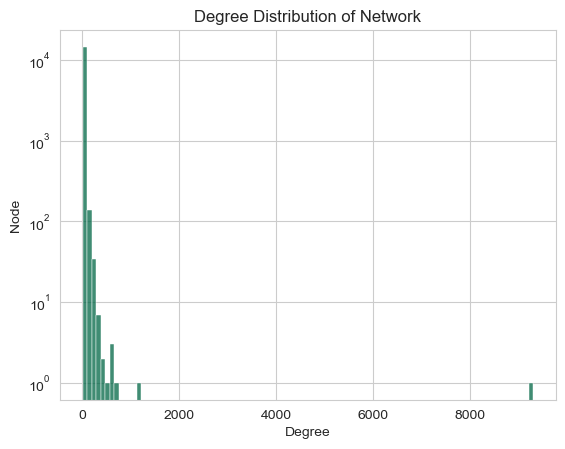

In [457]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Plot Node Degree Distribution
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Create a distribution plot
plt.figure()
# Plot the Histogram of the Nodes and their Degrees
sns.histplot(data=degrees_df,x=degrees_df['Connections_Count'], bins=100, color='#064',)

# Set Labels
plt.title('Degree Distribution of Network')
plt.xlabel('Degree')
plt.ylabel('Node')
plt.yscale('log')

plt.show()
plt.close()

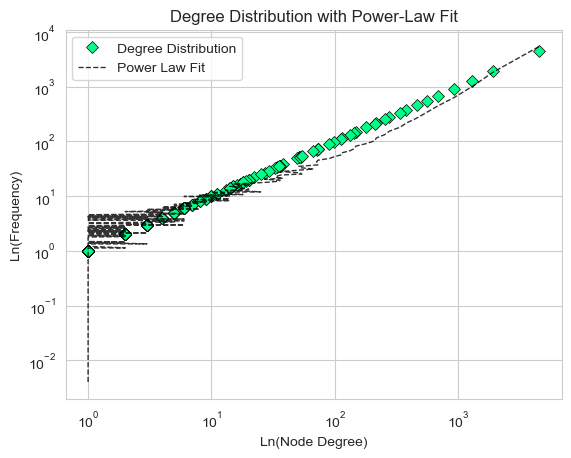

In [458]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Plot Node Degree Distribution
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Create a power law plot 
plt.figure()
plt.loglog(degrees, degree_frequencies, label='Degree Distribution',color='#0F8', marker='D',markeredgecolor='#000',markeredgewidth=0.5, linestyle='none')
plt.loglog(degrees, fit_line, label='Power Law Fit',color='#000',linewidth=1, linestyle='dashed',alpha=0.8) 
plt.title('Degree Distribution with Power-Law Fit')

plt.xlabel('Ln(Node Degree)')
plt.ylabel('Ln(Frequency)')

plt.legend()
plt.show()
plt.close()

In [459]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  STRONG POWER-LAW FIT SUGGESTS A SCALE FREE DISTRIBUTION
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print(f"-Slope of Degreee Distribution    : {-degree_reg_slope}")
print(f"Intercept of Degreee Distribution : {degree_reg_intercept}")
print(f"R-Squared of Degreee Distribution : {degree_reg_r**2}")
print(f"\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"HUMAN PROTEIN-PROTEIN INTERACTION NETWORK IS LIKELY SCALE-FREE \n"
      f"EVIDENCE: STRONG FIT (R = {-degree_reg_r}) WITH POWERLAW DISTRIBUTION")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

-Slope of Degreee Distribution    : 1.5477914347811732
Intercept of Degreee Distribution : 8.599820535314684
R-Squared of Degreee Distribution : 0.8574162022226708

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
HUMAN PROTEIN-PROTEIN INTERACTION NETWORK IS LIKELY SCALE-FREE 
EVIDENCE: STRONG FIT (R = 0.9259677112203594) WITH POWERLAW DISTRIBUTION
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [460]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Prepare Graph of Human PPI Network with NetworkX
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Create a graph of the Human PPI Network from the DataFrame
nx_human_ppi_graph = nx.from_pandas_edgelist(df= dfs['Human-PPI'], source='A',target= 'B')

# Initialize a list of the protein list dataframes
protein_lists_dfs = { 'L1': dfs['Protein-L1'], 'L2': dfs['Protein-L2'] }

In [461]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Get All Unique Protein Pairs per List
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Function generates all the unique pairs of Proteins within a List
def generate_pairs(protein_list):

    # Initalize a List of the Paired Proteins
    protein_pairs = []

    # Outer loop through the proteins of the list
    for protein_one in range(len(protein_list)):
        # Inner Loop through the remaining proteins by indexing+1 as protein two
        for protein_two in range(protein_one + 1, len(protein_list)):
            # Save the Protein Pair as a Tuple
            protein_pairs.append((protein_list[protein_one], protein_list[protein_two]))

    # Return the Protein Pairs per List
    return protein_pairs

In [462]:
# Initalize a Dict to Contain the Pairs of Proteins per List
protein_lists_pairs = {}

# Generate pairs per protein list
for i,protein_list in protein_lists_dfs.items():
    # Bind the Result to the New Dict
    protein_lists_pairs[i] = generate_pairs(protein_list['Protein'])

In [463]:
#print(protein_lists_pairs)

In [464]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Use PPI Network to Get Path Lengths of Protein Pairs per List
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Function to compute the shortest path length between two nodes within a tuple
# Requires the parent network graph as a nx graph to acquire the path length
def compute_path_lengths(network_graph, pair_list):
    # Intialize the Dict of Path Lengths
    path_lengths = {}
    
    # Iterate through the pairs within the pair list
    for node1, node2 in pair_list:
        
        # If the graph does not have either node
        if not network_graph.has_node(node1) or not network_graph.has_node(node2):
            continue

        # Compute the shortest path length between node1 and node2
        shortest_path_length = nx.shortest_path_length(network_graph, source=node1, target=node2)
        
        # Bind the shortest path length with the tuple as the key to the dict
        path_lengths[(node1, node2)] = shortest_path_length
    
    # Return the path lengths      
    return path_lengths

In [465]:
# Initalize a Dict to Contain the Pairs of Proteins per List
protein_lists_pairs_path_lengths = {}

# Generate pairs per protein list
for i,protein_list_pairs in protein_lists_pairs.items():
    
    # Bind the Result to the New Dict
    protein_lists_pairs_path_lengths[i] = compute_path_lengths(
        network_graph= nx_human_ppi_graph,
        pair_list=protein_list_pairs
    )

In [466]:
# pp(protein_lists_pairs_path_lengths)

C:\Users\ajaya\Conda\envs\B528-BMD\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


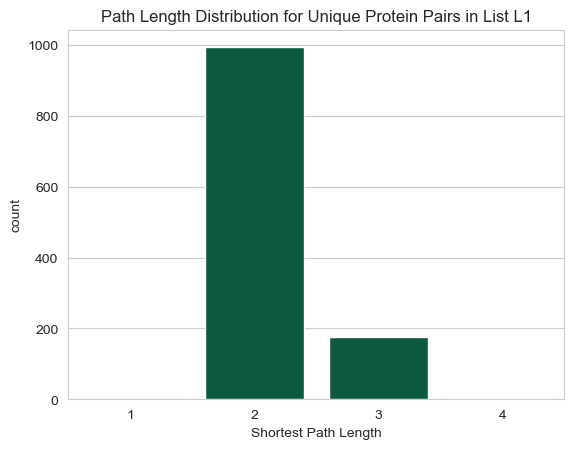

C:\Users\ajaya\Conda\envs\B528-BMD\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


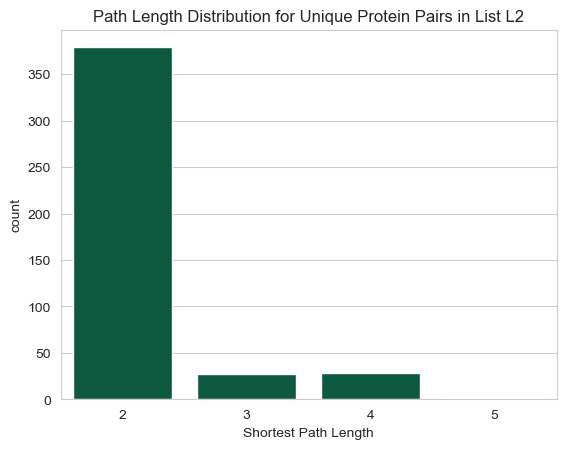

In [467]:
# Generate Distribution Plots to Inspect the Shortest Path Lengths
for i,protein_list_pairs_path_lengths in protein_lists_pairs_path_lengths.items():
    
    # Initalize a list to hold all the path lengths
    path_lengths = list(protein_list_pairs_path_lengths.values())
    
    # Plot the Count Plot
    plt.plot()    
    sns.countplot(x=path_lengths,color='#064')
    plt.title(f"Path Length Distribution for Unique Protein Pairs in List {i}")
    plt.xlabel('Shortest Path Length')
    plt.show()
    plt.close()

In [468]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Perform a Wilcoxon Test on the Path Length Distributions
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Extract just the Path Lengths
path_lengths_L1 = list(protein_lists_pairs_path_lengths['L1'].values())
path_lengths_L2 = list(protein_lists_pairs_path_lengths['L2'].values())

# Perform the Wilcoxon Rank-Sum Test
# Wilcoxon Test is alternatively known as the Mann-Whitney U test
# Non-parametric hypothesis test to check for significantly differing path lengths
path_length_dist_stat, path_length_dist_p_value = sp.stats.mannwhitneyu(path_lengths_L1, path_lengths_L2, alternative='two-sided')

print(f"Null Hypothesis Accepted & Alternate Hypothesis Rejected:")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"There is no significant median path length difference between the distrubtions\n"
      f"EVIDENCE: Wilcoxon Test ( P Value = {path_length_dist_p_value}) with Alpha = 0.05")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

Null Hypothesis Accepted & Alternate Hypothesis Rejected:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
There is no significant median path length difference between the distrubtions
EVIDENCE: Wilcoxon Test ( P Value = 0.4879477857940109) with Alpha = 0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [469]:
# ~~~~~~~~~~~~~~~
#  End of Script
# ~~~~~~~~~~~~~~~
